# Análisis Posts TikTok

In [1]:
# Importamos las librerías

import re
import nltk
import pandas as pd
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from nltk.tokenize import RegexpTokenizer

import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

###Diccionarios en español para el análisis de polaridad
nltk.download('punkt')
# Tokenización
# Descargar el conjunto de stopwords en español si no lo tienes
nltk.download('stopwords')
# Análisis de polaridad
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /home/cygnus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cygnus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
df_posts = pd.read_csv("tiktok_lomeli.csv", usecols=["video-count", "tiktok-j2a19r-SpanText", "tiktok-1p6dp51-StrongText", "tiktok-j2a19r-SpanText 2"])
df_posts = df_posts.rename(columns={"video-count":"views", "tiktok-j2a19r-SpanText":"texto1", "tiktok-1p6dp51-StrongText":"texto2", "tiktok-j2a19r-SpanText 2":"texto3"})
df_posts = df_posts[['texto1', 'texto2', 'texto3']]
df_posts = df_posts.fillna('')
df_posts["texto"] = df_posts.texto1 + ' ' + df_posts.texto2 + ' ' + df_posts.texto3
df_posts = df_posts.drop("texto1", axis=1)
df_posts = df_posts.drop("texto2", axis=1)
df_posts = df_posts.drop("texto3", axis=1)
df_posts

,texto
0,"Aquí estoy, con la cabeza en alto y el corazón..."
1,De doctor a doctora @Claudia Sheinbaum Pardo .
2,"Con la fuerza de la unidad, ¡estamos listos pa..."
3,En #morena hemos combatido permanentemente la ...
4,Mientras Movimiento Ciudadano y el Gobierno dd...
...,...
69,"No me gusta, me encanta!!! #DrCarlosLomeli"
70,Es un honor estar con Obrador! 🙌🏻 #DrCarlosLom...
71,Es que si está muy buena la canción 😅 #DrCarlo...
72,¡Feliz cumple 481 Guadalajara querida! #SanVal...


In [39]:
df_posts['texto'] = df_posts['texto'].apply(lambda x: re.sub(r"(, '[\W\.]')",r"", str(x)))
df_posts['texto'] = df_posts['texto'].str.lower()
df_posts['texto'] = df_posts['texto'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
tokenizer = RegexpTokenizer(r'\w+')
df_posts['tokens'] = df_posts['texto'].apply(nltk.tokenize.word_tokenize)
df_posts

,texto,tokens
0,aquí estoy con la cabeza en alto y el corazón ...,"[aquí, estoy, con, la, cabeza, en, alto, y, el..."
1,de doctor a doctora claudia sheinbaum pardo,"[de, doctor, a, doctora, claudia, sheinbaum, p..."
2,con la fuerza de la unidad estamos listos para...,"[con, la, fuerza, de, la, unidad, estamos, lis..."
3,en morena hemos combatido permanentemente la c...,"[en, morena, hemos, combatido, permanentemente..."
4,mientras movimiento ciudadano y el gobierno dd...,"[mientras, movimiento, ciudadano, y, el, gobie..."
...,...,...
69,no me gusta me encanta drcarloslomeli,"[no, me, gusta, me, encanta, drcarloslomeli]"
70,es un honor estar con obrador drcarloslomeli,"[es, un, honor, estar, con, obrador, drcarlosl..."
71,es que si está muy buena la canción drcarlosl...,"[es, que, si, está, muy, buena, la, canción, d..."
72,feliz cumple 481 guadalajara querida sanvalentin,"[feliz, cumple, 481, guadalajara, querida, san..."


In [40]:
# Limpieza de Stop_words
stop_words.extend(("q", "d", "van", "si", "pa", "así", "ser", "solo", "tan", "va", "as", "aquí", "hacia","dra", "día","hoy","dd","drcarloslomeli",
                "le", "con","ella", "qué", "por", "qu", "ers", "das", "ve", "jajaja", "jeje", "La", "nimo", "ms", "da","doccast",
                "drcarloslomeli"))

##########NUBE DE PALABRAS
def preprocess_text(text):
    words = text # Tokenizar y convertir a minúsculas
    words = [word for word in words if word.isalpha()]  # Eliminar caracteres no alfabéticos
    words = [word for word in words if word not in stop_words]  # Eliminar palabras vacías
    return words


preprocessed_text = df_posts["tokens"].apply(preprocess_text)

preprocessed_text

0     [cabeza, alto, corazón, encendido, punto, alca...
1          [doctor, doctora, claudia, sheinbaum, pardo]
2     [fuerza, unidad, listos, ganar, claudia, shein...
3     [morena, combatido, permanentemente, corrupció...
4     [mientras, movimiento, ciudadano, gobierno, gu...
                            ...                        
69                                     [gusta, encanta]
70                                     [honor, obrador]
71                                     [buena, canción]
72    [feliz, cumple, guadalajara, querida, sanvalen...
73     [mejor, inaugurar, tiktok, febrero, sanvalentin]
Name: tokens, Length: 74, dtype: object

In [41]:
# Unimos todas las listas de palabras en una sola lista
all_words = [word for sublist in preprocessed_text.values for word in sublist]

# Creamos un DataFrame con las palabras y sus frecuencias
word_counts = pd.Series(all_words).value_counts()

# Tomamos las palabras más comunes (puedes ajustar este valor según tus necesidades)
top_words = word_counts.head(10)
top_words.to_csv("top_words_posts.csv")

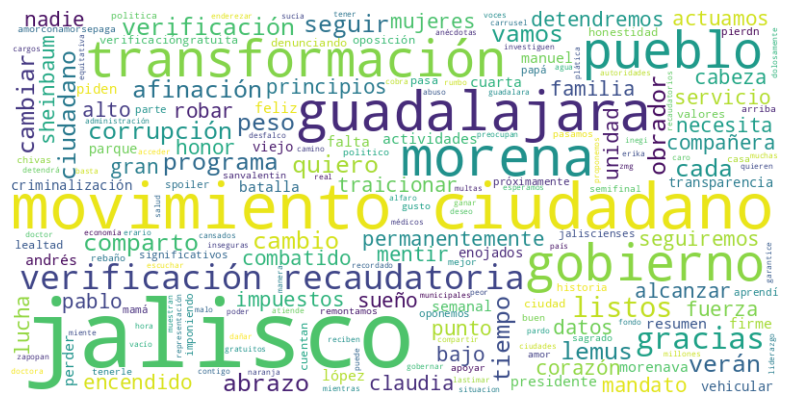

In [42]:
# Unir las palabras en un solo texto (separadas por espacios)
texto = " ".join(all_words)
# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(texto)
# Mostrar la nube de palabras utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Desactivar ejes
plt.show()

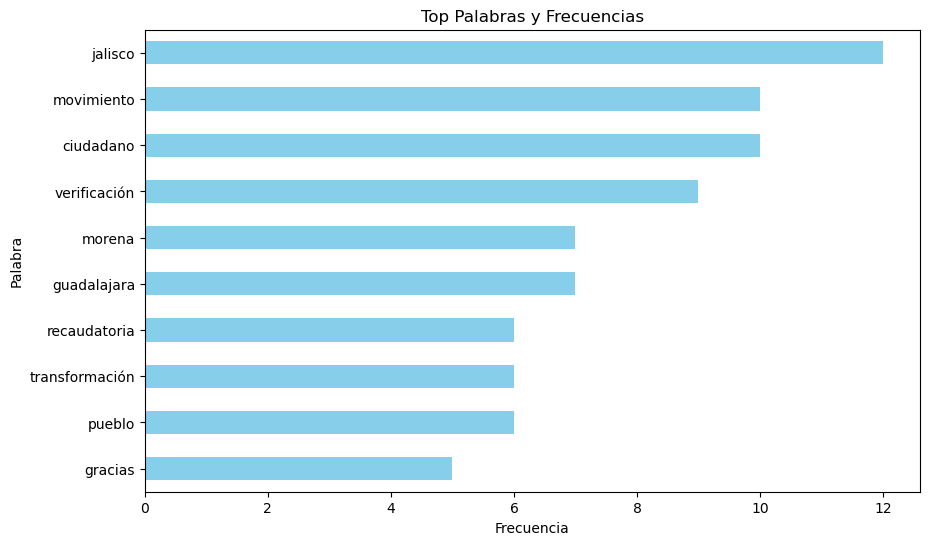

In [43]:
# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))
top_words.plot(kind='barh', color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Top Palabras y Frecuencias')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la palabra con la frecuencia más alta en la parte superior
plt.show()

## Topicos y Temas Emergentes

In [44]:
import spacy

nlp = spacy.load("es_core_news_sm")

# Función para preprocesar el texto
def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

# Aplicar el preprocesamiento a cada fila del DataFrame
df_posts['texto_preprocesado'] = df_posts.texto.apply(preprocess_text)
df_posts

,texto,tokens,texto_preprocesado
0,aquí estoy con la cabeza en alto y el corazón ...,"[aquí, estoy, con, la, cabeza, en, alto, y, el...","[cabeza, alto, corazón, encendido, punto, alca..."
1,de doctor a doctora claudia sheinbaum pardo,"[de, doctor, a, doctora, claudia, sheinbaum, p...","[doctor, doctoro, claudia, sheinbaum, pardo]"
2,con la fuerza de la unidad estamos listos para...,"[con, la, fuerza, de, la, unidad, estamos, lis...","[fuerza, unidad, listo, ganar, dra, claudia, s..."
3,en morena hemos combatido permanentemente la c...,"[en, morena, hemos, combatido, permanentemente...","[morena, combatir, permanentemente, corrupción..."
4,mientras movimiento ciudadano y el gobierno dd...,"[mientras, movimiento, ciudadano, y, el, gobie...","[movimiento, ciudadano, gobierno, dd, guadalar..."
...,...,...,...
69,no me gusta me encanta drcarloslomeli,"[no, me, gusta, me, encanta, drcarloslomeli]","[gustar, encantar, drcarloslomeli]"
70,es un honor estar con obrador drcarloslomeli,"[es, un, honor, estar, con, obrador, drcarlosl...","[honor, obrador, drcarloslomeli]"
71,es que si está muy buena la canción drcarlosl...,"[es, que, si, está, muy, buena, la, canción, d...","[canción, drcarloslomeli]"
72,feliz cumple 481 guadalajara querida sanvalentin,"[feliz, cumple, 481, guadalajara, querida, san...","[feliz, cumplir, guadalajara, querida, sanvale..."


In [45]:

from nltk.util import ngrams

# Generación de bigramas con spaCy
nlp = spacy.load("es_core_news_sm")

def generar_bigramas_spacy(texto):
    doc = nlp(texto)
    bigramas = [(doc[i].text, doc[i + 1].text) for i in range(len(doc) - 1)]
    return bigramas

df_posts['bigramas_spacy'] = df_posts['texto'].apply(generar_bigramas_spacy)

# Generación de bigramas con NLTK
def generar_bigramas_nltk(texto):
    tokens = word_tokenize(texto)
    bigramas = list(ngrams(tokens, 3))
    return bigramas

df_posts['bigramas_nltk'] = df_posts['texto'].apply(generar_bigramas_nltk)

# Visualización del DataFrame resultante
df_posts

,texto,tokens,texto_preprocesado,bigramas_spacy,bigramas_nltk
0,aquí estoy con la cabeza en alto y el corazón ...,"[aquí, estoy, con, la, cabeza, en, alto, y, el...","[cabeza, alto, corazón, encendido, punto, alca...","[(aquí, estoy), (estoy, con), (con, la), (la, ...","[(aquí, estoy, con), (estoy, con, la), (con, l..."
1,de doctor a doctora claudia sheinbaum pardo,"[de, doctor, a, doctora, claudia, sheinbaum, p...","[doctor, doctoro, claudia, sheinbaum, pardo]","[(de, doctor), (doctor, a), (a, doctora), (doc...","[(de, doctor, a), (doctor, a, doctora), (a, do..."
2,con la fuerza de la unidad estamos listos para...,"[con, la, fuerza, de, la, unidad, estamos, lis...","[fuerza, unidad, listo, ganar, dra, claudia, s...","[(con, la), (la, fuerza), (fuerza, de), (de, l...","[(con, la, fuerza), (la, fuerza, de), (fuerza,..."
3,en morena hemos combatido permanentemente la c...,"[en, morena, hemos, combatido, permanentemente...","[morena, combatir, permanentemente, corrupción...","[(en, morena), (morena, hemos), (hemos, combat...","[(en, morena, hemos), (morena, hemos, combatid..."
4,mientras movimiento ciudadano y el gobierno dd...,"[mientras, movimiento, ciudadano, y, el, gobie...","[movimiento, ciudadano, gobierno, dd, guadalar...","[(mientras, movimiento), (movimiento, ciudadan...","[(mientras, movimiento, ciudadano), (movimient..."
...,...,...,...,...,...
69,no me gusta me encanta drcarloslomeli,"[no, me, gusta, me, encanta, drcarloslomeli]","[gustar, encantar, drcarloslomeli]","[(no, me), (me, gusta), (gusta, me), (me, enca...","[(no, me, gusta), (me, gusta, me), (gusta, me,..."
70,es un honor estar con obrador drcarloslomeli,"[es, un, honor, estar, con, obrador, drcarlosl...","[honor, obrador, drcarloslomeli]","[(es, un), (un, honor), (honor, estar), (estar...","[(es, un, honor), (un, honor, estar), (honor, ..."
71,es que si está muy buena la canción drcarlosl...,"[es, que, si, está, muy, buena, la, canción, d...","[canción, drcarloslomeli]","[(es, que), (que, si), (si, está), (está, muy)...","[(es, que, si), (que, si, está), (si, está, mu..."
72,feliz cumple 481 guadalajara querida sanvalentin,"[feliz, cumple, 481, guadalajara, querida, san...","[feliz, cumplir, guadalajara, querida, sanvale...","[(feliz, cumple), (cumple, 481), (481, guadala...","[(feliz, cumple, 481), (cumple, 481, guadalaja..."


In [46]:
from nltk.collocations import *

flatten_corpus = [w for l in df_posts.bigramas_spacy for w in l]

treshold = 3

bigrams = [bigram for bigram in flatten_corpus if len(bigram[0])>treshold and len(bigram[1])>treshold]

In [47]:
bigram_measure = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(bigrams)
finder.apply_freq_filter(2)
colocaciones = finder.nbest(bigram_measure.pmi, 20)
colocaciones

[('aquí', 'estoy'),
 ('buen', 'politico'),
 ('corazón', 'encendido'),
 ('pablo', 'lemus'),
 ('piden', 'verificacióngratuita'),
 ('pueblo', 'politica'),
 ('rebaño', 'sagrado'),
 ('resumen', 'semanal'),
 ('semifinal', 'arriba'),
 ('tenerle', 'amor'),
 ('verán', 'próximamente'),
 ('papá', 'doccast'),
 ('seguir', 'denunciando'),
 ('actuamos', 'bajo'),
 ('ciudad', 'cuentan'),
 ('combatido', 'permanentemente'),
 ('cuarta', 'transformación'),
 ('lópez', 'obrador'),
 ('mucho', 'amorconamorsepaga'),
 ('nuestra', 'ciudad')]

In [53]:

# Función para lematizar el texto
def lematizar_texto(texto):
    doc = nlp(texto)
    lemas = [token.lemma_ for token in doc]
    return " ".join(lemas)

# Aplicar la función de lematización a cada fila del DataFrame
df_posts['texto_lematizado'] = df_posts.texto.apply(lematizar_texto)
df_posts

,texto,tokens,texto_preprocesado,bigramas_spacy,bigramas_nltk,texto_lematizado
0,aquí estoy con la cabeza en alto y el corazón ...,"[aquí, estoy, con, la, cabeza, en, alto, y, el...","[cabeza, alto, corazón, encendido, punto, alca...","[(aquí, estoy), (estoy, con), (con, la), (la, ...","[(aquí, estoy, con), (estoy, con, la), (con, l...",aquí estar con el cabeza en alto y el corazón ...
1,de doctor a doctora claudia sheinbaum pardo,"[de, doctor, a, doctora, claudia, sheinbaum, p...","[doctor, doctoro, claudia, sheinbaum, pardo]","[(de, doctor), (doctor, a), (a, doctora), (doc...","[(de, doctor, a), (doctor, a, doctora), (a, do...",de doctor a doctoro claudia sheinbaum pardo
2,con la fuerza de la unidad estamos listos para...,"[con, la, fuerza, de, la, unidad, estamos, lis...","[fuerza, unidad, listo, ganar, dra, claudia, s...","[(con, la), (la, fuerza), (fuerza, de), (de, l...","[(con, la, fuerza), (la, fuerza, de), (fuerza,...",con el fuerza de el unidad estar listo para ga...
3,en morena hemos combatido permanentemente la c...,"[en, morena, hemos, combatido, permanentemente...","[morena, combatir, permanentemente, corrupción...","[(en, morena), (morena, hemos), (hemos, combat...","[(en, morena, hemos), (morena, hemos, combatid...",en morena haber combatir permanentemente el co...
4,mientras movimiento ciudadano y el gobierno dd...,"[mientras, movimiento, ciudadano, y, el, gobie...","[movimiento, ciudadano, gobierno, dd, guadalar...","[(mientras, movimiento), (movimiento, ciudadan...","[(mientras, movimiento, ciudadano), (movimient...",mientras movimiento ciudadano y el gobierno dd...
...,...,...,...,...,...,...
69,no me gusta me encanta drcarloslomeli,"[no, me, gusta, me, encanta, drcarloslomeli]","[gustar, encantar, drcarloslomeli]","[(no, me), (me, gusta), (gusta, me), (me, enca...","[(no, me, gusta), (me, gusta, me), (gusta, me,...",no yo gustar yo encantar drcarloslomeli
70,es un honor estar con obrador drcarloslomeli,"[es, un, honor, estar, con, obrador, drcarlosl...","[honor, obrador, drcarloslomeli]","[(es, un), (un, honor), (honor, estar), (estar...","[(es, un, honor), (un, honor, estar), (honor, ...",ser uno honor estar con obrador drcarloslomeli
71,es que si está muy buena la canción drcarlosl...,"[es, que, si, está, muy, buena, la, canción, d...","[canción, drcarloslomeli]","[(es, que), (que, si), (si, está), (está, muy)...","[(es, que, si), (que, si, está), (si, está, mu...",ser que si estar mucho buen el canción drcar...
72,feliz cumple 481 guadalajara querida sanvalentin,"[feliz, cumple, 481, guadalajara, querida, san...","[feliz, cumplir, guadalajara, querida, sanvale...","[(feliz, cumple), (cumple, 481), (481, guadala...","[(feliz, cumple, 481), (cumple, 481, guadalaja...",feliz cumplir 481 guadalajara querida sanvalentin


In [65]:
# Aplicar el preprocesamiento a cada fila del DataFrame

texts = [[word for word in word_tokenize(document.lower()) if word not in stop_words] for document in df_posts.texto_lematizado]

# Crear un diccionario a partir de los documentos preprocesados
dictionary = corpora.Dictionary(texts)
dictionary.add_documents(colocaciones)  # Agregar n-gramas al diccionario


# Crear una representación BoW de los documentos
corpus = [dictionary.doc2bow(texto) for texto in df_posts['texto_preprocesado']]

num_topics = 8  # Ajusta el número de tópicos según tus necesidades
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Obtener los temas y sus palabras clave
topics = lda_model.print_topics(num_words=15)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.043*"politico" + 0.033*"doccast" + 0.022*"gracia" + 0.022*"lealtad" + 0.022*"mamá" + 0.022*"significativo" + 0.022*"honestidad" + 0.022*"valor" + 0.022*"papá" + 0.022*"aprender" + 0.022*"amorconamorsepacer" + 0.022*"historia" + 0.022*"abrazo" + 0.022*"querer" + 0.022*"amor"')
(1, '0.041*"programa" + 0.031*"ciudadano" + 0.028*"verificación" + 0.028*"enojado" + 0.028*"verificacióngratuita" + 0.028*"falta" + 0.028*"pedir" + 0.028*"transparencia" + 0.028*"criminalización" + 0.028*"viejo" + 0.028*"parque" + 0.028*"vehicular" + 0.028*"jalisco" + 0.015*"obrador" + 0.015*"abrazo"')
(2, '0.045*"jalisco" + 0.036*"morena" + 0.027*"gobierno" + 0.019*"transformación" + 0.019*"pueblo" + 0.019*"celebrar" + 0.019*"firme" + 0.019*"cambiar" + 0.019*"cambio" + 0.019*"caro" + 0.019*"querer" + 0.010*"ver" + 0.010*"obrador" + 0.010*"llegar" + 0.010*"morenava"')
(3, '0.041*"guadalajara" + 0.041*"seguir" + 0.041*"ciudad" + 0.041*"pasar" + 0.041*"denunciar" + 0.041*"oposición" + 0.041*"contar" + 0.022*"

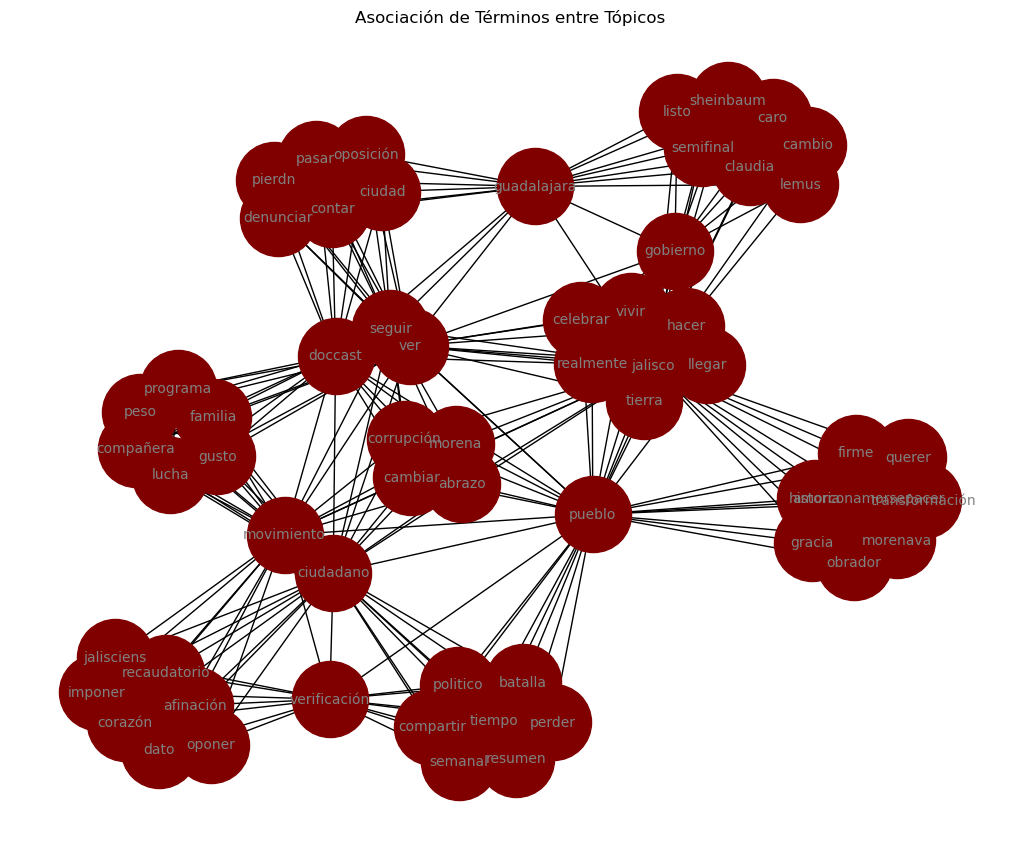

In [64]:
import networkx as nx

# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='gray')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

### Extraer palabras de Topics

In [169]:
# Crear una lista de diccionarios para cada tema y sus palabras relacionadas
data = []
for topic, words in topics:
    # Utiliza una expresión regular para extraer las palabras entre comillas dobles
    data.append({'Tema': topic, 'Palabras Relacionadas': words})

# Crear un DataFrame a partir de la lista de diccionarios
df = pd.DataFrame(data)


#words = re.findall(r'"(.*?)"', topics[0][0])


topic_text = topics[5][1]

words = re.findall(r'"(.*?)"', topic_text)
words

['tiempo',
 'resumen',
 'actividad',
 'batalla',
 'ciudad',
 'oposición',
 'morena',
 'impuesto',
 'servicio',
 'febrero']

# Topics con Spacy

In [95]:
# eliminar la función ner para acelerar el procesamiento
nlp.disable_pipes('ner')

['ner']

In [96]:
print(nlp.pipe_names)

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer']


In [297]:
from tqdm import tqdm

# dataset
dataset = df_posts['texto']
docs = []
for text in tqdm(nlp.pipe(dataset), total=len(dataset)):
    doc = nlp(text) 
    pt = [token.lemma_.lower() for token in doc if
           (len(token.lemma_) > 1 and token.pos_ == "NOUN" and 
          not token.is_stop)]
    docs.append(pt)
    
docs

100%|██████████| 74/74 [00:00<00:00, 130.82it/s]


[['cabeza', 'alto', 'corazón', 'punto', 'sueño'],
 ['doctor', 'claudia'],
 ['fuerza', 'unidad', 'dra', 'claudia', 'transformación', 'jalisco', '2024'],
 ['morena', 'corrupción', 'movimiento', 'principio', 'mandato', 'pueblo'],
 ['movimiento', 'impuesto', 'morena', 'servicio'],
 ['vacío', 'carrusel', 'pablo', 'voz', 'corrupción', 'hora', 'cambio'],
 ['autoridad',
  'fondo',
  'desfalco',
  'millón',
  'pesos',
  'erario',
  'administración',
  'pablo'],
 ['dato', 'inegi', 'ciudad', 'país'],
 ['ciudadano', 'agua', 'salud', 'situacion', 'peso', 'peso', 'servicio'],
 ['abuso', 'movimiento', 'transformación', 'camino'],
 ['dato', 'tiempo', 'rumbo'],
 ['familia', 'anécdota'],
 ['movimiento', 'economía', 'familia', 'multa', 'impuesto', 'programa'],
 ['gobierno',
  'mujer',
  'cargo',
  'liderazgo',
  'representación',
  'toma',
  'decisión'],
 ['episodio', 'oportunidad', 'compañera', 'lucha'],
 ['abrazo', 'sonrisa', 'muestra', 'cariño', 'fuerza'],
 ['honor', 'lucha', 'mujer'],
 [],
 ['preside

In [298]:
from collections import Counter
from itertools import chain

counts_word_occurence = Counter(chain(*[x for x in docs]))

# Palabras con una sola ocurrencia
low_freq_words = {key:value for (key,value) in counts_word_occurence.items() if value==1}
docs = [[lemma for lemma in text if counts_word_occurence[lemma]>0] for text in docs]



In [299]:
docs

[['cabeza', 'alto', 'corazón', 'punto', 'sueño'],
 ['doctor', 'claudia'],
 ['fuerza', 'unidad', 'dra', 'claudia', 'transformación', 'jalisco', '2024'],
 ['morena', 'corrupción', 'movimiento', 'principio', 'mandato', 'pueblo'],
 ['movimiento', 'impuesto', 'morena', 'servicio'],
 ['vacío', 'carrusel', 'pablo', 'voz', 'corrupción', 'hora', 'cambio'],
 ['autoridad',
  'fondo',
  'desfalco',
  'millón',
  'pesos',
  'erario',
  'administración',
  'pablo'],
 ['dato', 'inegi', 'ciudad', 'país'],
 ['ciudadano', 'agua', 'salud', 'situacion', 'peso', 'peso', 'servicio'],
 ['abuso', 'movimiento', 'transformación', 'camino'],
 ['dato', 'tiempo', 'rumbo'],
 ['familia', 'anécdota'],
 ['movimiento', 'economía', 'familia', 'multa', 'impuesto', 'programa'],
 ['gobierno',
  'mujer',
  'cargo',
  'liderazgo',
  'representación',
  'toma',
  'decisión'],
 ['episodio', 'oportunidad', 'compañera', 'lucha'],
 ['abrazo', 'sonrisa', 'muestra', 'cariño', 'fuerza'],
 ['honor', 'lucha', 'mujer'],
 [],
 ['preside

In [300]:
docs_length=len(docs)
docs

[['cabeza', 'alto', 'corazón', 'punto', 'sueño'],
 ['doctor', 'claudia'],
 ['fuerza', 'unidad', 'dra', 'claudia', 'transformación', 'jalisco', '2024'],
 ['morena', 'corrupción', 'movimiento', 'principio', 'mandato', 'pueblo'],
 ['movimiento', 'impuesto', 'morena', 'servicio'],
 ['vacío', 'carrusel', 'pablo', 'voz', 'corrupción', 'hora', 'cambio'],
 ['autoridad',
  'fondo',
  'desfalco',
  'millón',
  'pesos',
  'erario',
  'administración',
  'pablo'],
 ['dato', 'inegi', 'ciudad', 'país'],
 ['ciudadano', 'agua', 'salud', 'situacion', 'peso', 'peso', 'servicio'],
 ['abuso', 'movimiento', 'transformación', 'camino'],
 ['dato', 'tiempo', 'rumbo'],
 ['familia', 'anécdota'],
 ['movimiento', 'economía', 'familia', 'multa', 'impuesto', 'programa'],
 ['gobierno',
  'mujer',
  'cargo',
  'liderazgo',
  'representación',
  'toma',
  'decisión'],
 ['episodio', 'oportunidad', 'compañera', 'lucha'],
 ['abrazo', 'sonrisa', 'muestra', 'cariño', 'fuerza'],
 ['honor', 'lucha', 'mujer'],
 [],
 ['preside

In [301]:
# Dropping words that occur in more then 40% of the articles

# Getting the corpus length 
docs_length=len(docs)

# calculate in how many documents a word appeared
counts_word_percentage = Counter(chain(*[set(x) for x in docs]))

# calculate in what % of all articles a word appears
counts_word_percentage = {key:(value/docs_length)*100 for (key,value) in counts_word_percentage.items()}
high_freq_words = {key:value for (key,value) in counts_word_percentage.items() if value>5}

high_freq_words


{'transformación': 8.108108108108109,
 'morena': 9.45945945945946,
 'pueblo': 8.108108108108109,
 'movimiento': 13.513513513513514,
 'verificación': 9.45945945945946}

In [302]:
import pprint

pp = pprint.PrettyPrinter(compact=True)
pp.pprint(docs)

[['cabeza', 'alto', 'corazón', 'punto', 'sueño'], ['doctor', 'claudia'],
 ['fuerza', 'unidad', 'dra', 'claudia', 'transformación', 'jalisco', '2024'],
 ['morena', 'corrupción', 'movimiento', 'principio', 'mandato', 'pueblo'],
 ['movimiento', 'impuesto', 'morena', 'servicio'],
 ['vacío', 'carrusel', 'pablo', 'voz', 'corrupción', 'hora', 'cambio'],
 ['autoridad', 'fondo', 'desfalco', 'millón', 'pesos', 'erario',
  'administración', 'pablo'],
 ['dato', 'inegi', 'ciudad', 'país'],
 ['ciudadano', 'agua', 'salud', 'situacion', 'peso', 'peso', 'servicio'],
 ['abuso', 'movimiento', 'transformación', 'camino'],
 ['dato', 'tiempo', 'rumbo'], ['familia', 'anécdota'],
 ['movimiento', 'economía', 'familia', 'multa', 'impuesto', 'programa'],
 ['gobierno', 'mujer', 'cargo', 'liderazgo', 'representación', 'toma',
  'decisión'],
 ['episodio', 'oportunidad', 'compañera', 'lucha'],
 ['abrazo', 'sonrisa', 'muestra', 'cariño', 'fuerza'],
 ['honor', 'lucha', 'mujer'], [],
 ['presidente', 'mañanera', 'volunt

<Axes: ylabel='Count'>

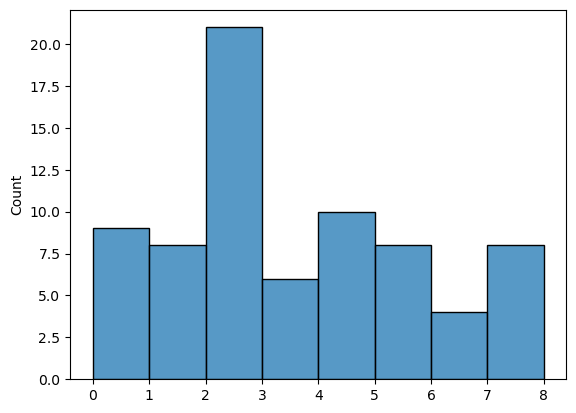

In [303]:
import seaborn as sns 

lengths =  [len(x) for x in docs]
# Build the histogram, distribution of lemmas in the texts
sns.histplot(lengths)

In [314]:
from gensim.models import CoherenceModel

# Defining dictionary and corpus with Gensim
dictionary = corpora.Dictionary(docs)
#dictionary.add_documents(colocaciones)  # Agregar n-gramas al diccionario

corpus = [dictionary.doc2bow(text) for text in docs]

def calculate_coherence(dictionary, corpus, docs, start, stop):
    scores = []
    for topics in range(start, stop):

        # defining the model
        lda_model = LdaModel(corpus, id2word=dictionary, num_topics=26, alpha='auto', eval_every=5)

        # U_mass coherence score
        cm_u_mass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        u_mass_coherence = cm_u_mass.get_coherence()

        # C_v coherence score
        cm_c_v = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
        c_v_coherence = cm_c_v.get_coherence()

        values = [topics, u_mass_coherence, c_v_coherence]

        scores.append(values)

    return scores

# calculare scores
scores = calculate_coherence(dictionary, corpus, docs, 5, 15)
scores


[[5, -19.96013056671264, 0.5422807191197031],
 [6, -19.88699593398828, 0.5368366228852124],
 [7, -19.831548458768882, 0.5350306126522217],
 [8, -19.830405277923568, 0.5389289003203526],
 [9, -19.954235381438387, 0.5410488557836974],
 [10, -19.902495267674393, 0.5384843855240472],
 [11, -19.879696024797752, 0.5410658621177376],
 [12, -19.95417286747886, 0.5390445339524796],
 [13, -19.921627177993614, 0.5448068879890717],
 [14, -19.710928217627295, 0.5211523171377606]]

Text(0.5, 1.0, 'u_mass coherence')

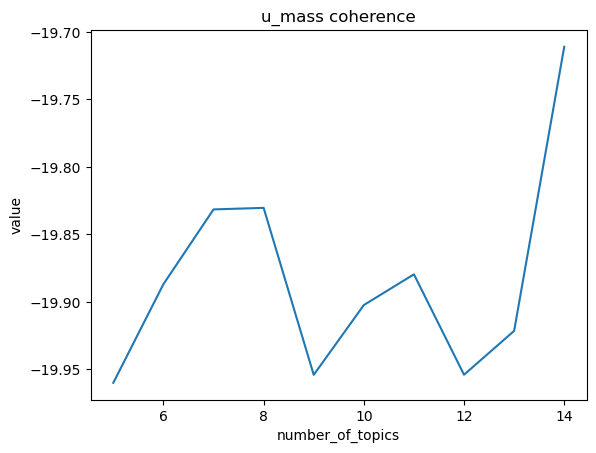

In [315]:
# scores to df
df = pd.DataFrame(scores, columns = ['number_of_topics','u_mass_coherence','c_v_coherence'])

# tidying the df
df = df.melt(id_vars=['number_of_topics'], value_vars=['u_mass_coherence','c_v_coherence'])

# Plotting u_mass_coherence
sns.lineplot(data=df.loc[df['variable'] == 'u_mass_coherence'], x="number_of_topics", y="value").set_title('u_mass coherence')

Text(0.5, 1.0, 'c_v coherence')

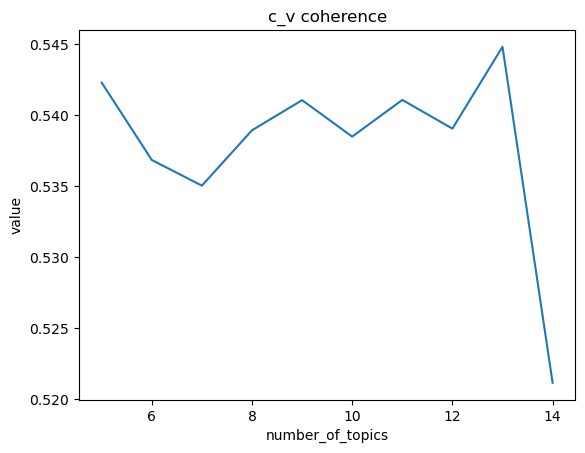

In [316]:
# Plotting c_v_coherence
sns.lineplot(data=df.loc[df['variable'] == 'c_v_coherence'], x="number_of_topics", y="value").set_title('c_v coherence')


In [317]:
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=8, alpha='auto', eval_every=5, passes=10)

# print topics
topics = lda_model.print_topics(-1)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.051*"gobierno" + 0.051*"transformación" + 0.051*"punto" + 0.051*"corazón" + 0.051*"sueño" + 0.051*"alto" + 0.051*"cabeza" + 0.027*"movimiento" + 0.027*"tierra" + 0.027*"dignidad"')
(1, '0.121*"morena" + 0.083*"pueblo" + 0.044*"rebaño" + 0.044*"chiva" + 0.044*"casa" + 0.044*"semifinal" + 0.044*"doccast" + 0.044*"spoiler" + 0.044*"amor" + 0.023*"cambio"')
(2, '0.121*"verificación" + 0.088*"movimiento" + 0.051*"afinación" + 0.037*"transformación" + 0.037*"peso" + 0.037*"jalisciens" + 0.019*"gusto" + 0.019*"servicio" + 0.019*"ciudadano" + 0.019*"situacion"')
(3, '0.060*"gracia" + 0.041*"jalisco" + 0.041*"historia" + 0.028*"2024" + 0.023*"morena" + 0.022*"claudia" + 0.022*"unidad" + 0.022*"transformación" + 0.022*"pablo" + 0.022*"fuerza"')
(4, '0.047*"tiempo" + 0.047*"resumen" + 0.047*"batalla" + 0.047*"actividad" + 0.047*"oposición" + 0.047*"ciudad" + 0.025*"lucha" + 0.025*"sonrisa" + 0.025*"muestra" + 0.025*"cariño"')
(5, '0.072*"lealtad" + 0.072*"honestidad" + 0.072*"mamá" + 0.072

In [320]:
topic_text = topics[5][1]

words = re.findall(r'"(.*?)"', topic_text)
words

['lealtad',
 'honestidad',
 'mamá',
 'papá',
 'valor',
 'momento',
 'gracias',
 'gusto',
 'morena',
 'movimiento']

In [228]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
viz


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.181665  0.086383       1        1  21.281088
0     -0.171257  0.128959       2        1  19.241971
5     -0.027044 -0.188920       3        1  16.801822
6      0.057940  0.003452       4        1  16.588051
2     -0.038227 -0.028187       5        1  15.739753
4     -0.001988 -0.003419       6        1   5.379689
3     -0.000545  0.000866       7        1   2.483822
7     -0.000545  0.000866       8        1   2.483805, topic_info=             Term      Freq     Total Category  logprob  loglift
38       historia  1.000000  1.000000  Default  30.0000  30.0000
20     presidente  1.000000  1.000000  Default  29.0000  29.0000
41         rebaño  1.000000  1.000000  Default  28.0000  28.0000
39           casa  1.000000  1.000000  Default  27.0000  27.0000
40          chiva  1.000000  1.000000  Default  26.0000  26.0000
..            ...       ...       ...      ...      ...      ...
15           peso  0.029806  1.705433   Topic8  -4.3175  -0.3515
27  transparencia  0.029806  1.705434   Topic8  -4.3175  -0.3515
40          chiva  0.029806  1.686689   Topic8  -4.3175  -0.3404
41         rebaño  0.029806  1.686689   Topic8  -4.3175  -0.3404
31        lealtad  0.029806  1.675458   Topic8  -4.3175  -0.3338

[464 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
6         2  0.598788                  2024
21        5  0.592878             actividad
0         1  0.571957                  alto
43        2  0.598815                  amor
22        5  0.592878               batalla
1         1  0.571957                cabeza
39        5  0.592878                  casa
40        5  0.592878                 chiva
5         2  0.598806               claudia
2         1  0.571957               corazón
24        4  0.586361       criminalización
14        4  0.586363                  dato
36        2  0.598758               doccast
25        4  0.586361                 falta
16        1  0.571897               familia
7         2  0.598814                fuerza
44        1  0.572167                 gusto
38        6  0.827476              historia
30        3  0.596852            honestidad
19        2  0.598758                 honor
11        1  0.571896              impuesto
35        3  0.596854            jalisciens
31        3  0.596852               lealtad
18        2  0.598814                 lucha
32        3  0.596852                  mamá
9         1  0.572009               mandato
17        2  0.598814                 mujer
29        3  0.596854             oposición
13        3  0.596854                 pablo
33        3  0.596852                  papá
26        4  0.586361                parque
15        4  0.586361                  peso
20        6  0.826032            presidente
10        1  0.572010             principio
3         1  0.571957                 punto
41        5  0.592878                rebaño
23        5  0.592878               resumen
42        5  0.592878             semifinal
12        1  0.579040              servicio
12        4  0.579040              servicio
37        2  0.598758               spoiler
4         1  0.571957                 sueño
27        4  0.586361         transparencia
8         2  0.598323                unidad
34        3  0.596852                 valor
28        4  0.586361  verificacióngratuita, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 6, 7, 3, 5, 4, 8])

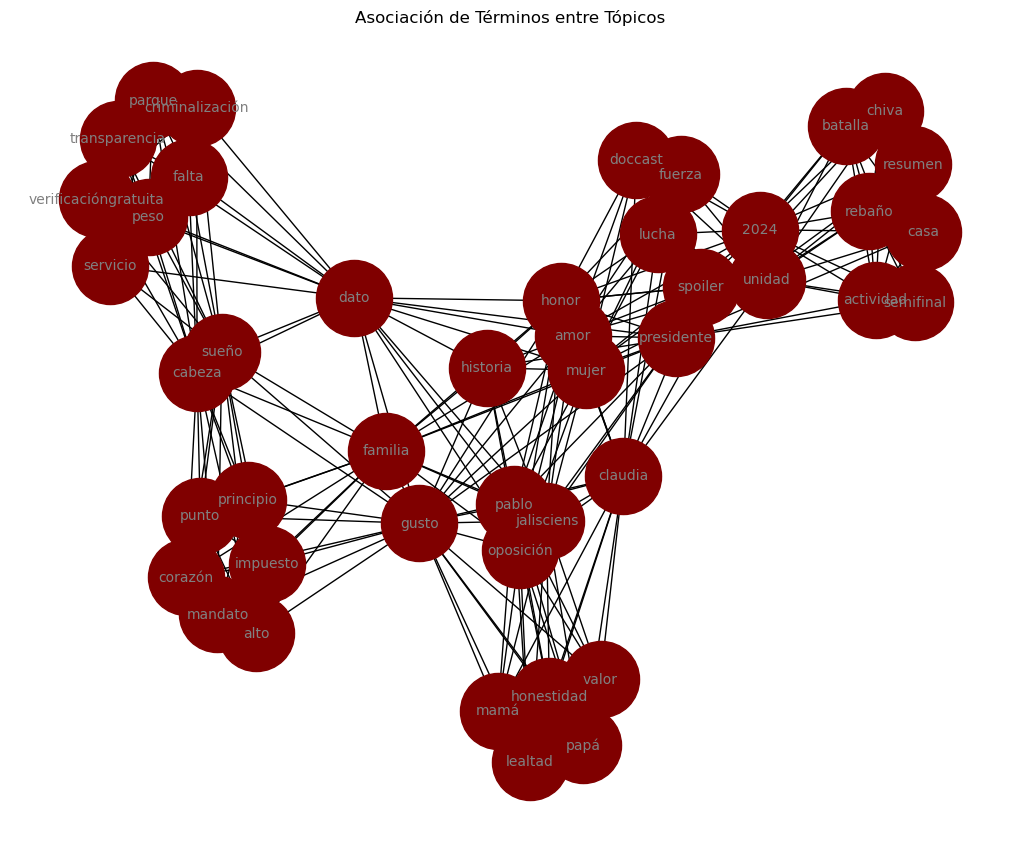

In [229]:
import networkx as nx

# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='gray')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

In [66]:
from sentiment_analysis_spanish import sentiment_analysis

sentiment = sentiment_analysis.SentimentAnalysisSpanish()

/usr/lib64/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib64/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [67]:
# Cálculo de la Polaridad 

def polaridad(texto):
    sentiment = sentiment_analysis.SentimentAnalysisSpanish()
    return sentiment.sentiment(texto)

In [69]:
df_posts["polaridad"] = df_posts["texto"].apply(polaridad)
df_posts

/usr/lib64/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib64/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,texto,tokens,texto_preprocesado,bigramas_spacy,bigramas_nltk,texto_lematizado,polaridad
0,aquí estoy con la cabeza en alto y el corazón ...,"[aquí, estoy, con, la, cabeza, en, alto, y, el...","[cabeza, alto, corazón, encendido, punto, alca...","[(aquí, estoy), (estoy, con), (con, la), (la, ...","[(aquí, estoy, con), (estoy, con, la), (con, l...",aquí estar con el cabeza en alto y el corazón ...,0.783798
1,de doctor a doctora claudia sheinbaum pardo,"[de, doctor, a, doctora, claudia, sheinbaum, p...","[doctor, doctoro, claudia, sheinbaum, pardo]","[(de, doctor), (doctor, a), (a, doctora), (doc...","[(de, doctor, a), (doctor, a, doctora), (a, do...",de doctor a doctoro claudia sheinbaum pardo,0.461278
2,con la fuerza de la unidad estamos listos para...,"[con, la, fuerza, de, la, unidad, estamos, lis...","[fuerza, unidad, listo, ganar, dra, claudia, s...","[(con, la), (la, fuerza), (fuerza, de), (de, l...","[(con, la, fuerza), (la, fuerza, de), (fuerza,...",con el fuerza de el unidad estar listo para ga...,0.003089
3,en morena hemos combatido permanentemente la c...,"[en, morena, hemos, combatido, permanentemente...","[morena, combatir, permanentemente, corrupción...","[(en, morena), (morena, hemos), (hemos, combat...","[(en, morena, hemos), (morena, hemos, combatid...",en morena haber combatir permanentemente el co...,0.000004
4,mientras movimiento ciudadano y el gobierno dd...,"[mientras, movimiento, ciudadano, y, el, gobie...","[movimiento, ciudadano, gobierno, dd, guadalar...","[(mientras, movimiento), (movimiento, ciudadan...","[(mientras, movimiento, ciudadano), (movimient...",mientras movimiento ciudadano y el gobierno dd...,0.108965
...,...,...,...,...,...,...,...
69,no me gusta me encanta drcarloslomeli,"[no, me, gusta, me, encanta, drcarloslomeli]","[gustar, encantar, drcarloslomeli]","[(no, me), (me, gusta), (gusta, me), (me, enca...","[(no, me, gusta), (me, gusta, me), (gusta, me,...",no yo gustar yo encantar drcarloslomeli,0.262592
70,es un honor estar con obrador drcarloslomeli,"[es, un, honor, estar, con, obrador, drcarlosl...","[honor, obrador, drcarloslomeli]","[(es, un), (un, honor), (honor, estar), (estar...","[(es, un, honor), (un, honor, estar), (honor, ...",ser uno honor estar con obrador drcarloslomeli,0.580164
71,es que si está muy buena la canción drcarlosl...,"[es, que, si, está, muy, buena, la, canción, d...","[canción, drcarloslomeli]","[(es, que), (que, si), (si, está), (está, muy)...","[(es, que, si), (que, si, está), (si, está, mu...",ser que si estar mucho buen el canción drcar...,0.898975
72,feliz cumple 481 guadalajara querida sanvalentin,"[feliz, cumple, 481, guadalajara, querida, san...","[feliz, cumplir, guadalajara, querida, sanvale...","[(feliz, cumple), (cumple, 481), (481, guadala...","[(feliz, cumple, 481), (cumple, 481, guadalaja...",feliz cumplir 481 guadalajara querida sanvalentin,0.653747


In [72]:
import numpy as np
mediana = np.median(df_posts.polaridad)
df_posts.polaridad.describe()

count    7.400000e+01
mean     2.130223e-01
std      2.625764e-01
min      8.120523e-10
25%      5.873649e-03
50%      7.706191e-02
75%      3.558275e-01
max      8.989752e-01
Name: polaridad, dtype: float64

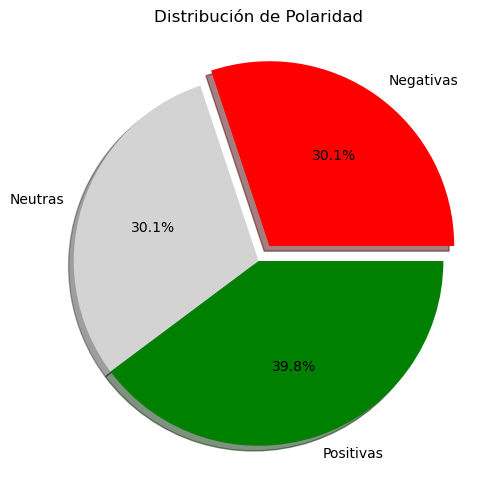

In [75]:
# Clasificar las polaridades en negativas, neutras y positivas
negativas = df_posts[(df_posts['polaridad'] < mediana/2)]
neutras = df_posts[(df_posts['polaridad'] < mediana/2) & (df_posts['polaridad'] <= mediana)]
positivas = df_posts[(df_posts['polaridad'] > mediana)]


# Contar cuántos elementos hay en cada categoría
num_negativas = len(negativas)
num_neutras = len(neutras)
num_positivas = len(positivas)

# Crear la gráfica de pastel
labels = ['Negativas', 'Neutras', 'Positivas']
sizes = [num_negativas, num_neutras, num_positivas]
colors = ['red', 'lightgray', 'green']
explode = (0.1, 0, 0)  # Para resaltar la categoría de negativas

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', shadow=True)
plt.title('Distribución de Polaridad')
plt.show()